# Vision Transformer on CIFAR-10

In [ ]:
%%capture
!pip install pytorch-ignite
!pip install timm
!pip install ipdb
!pip install einops
!pip install einsum
!pip install fvcore

## Imports

In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import seaborn as sns
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import _LRScheduler


import ignite.metrics
import ignite.contrib.handlers
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor

from tqdm import tqdm
import random

## Parser

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch Transformer Vision Model')

parser.add_argument('--DATA_DIR', type=str, default='./data',
                    help='Data directory')
parser.add_argument('--BATCH_SIZE', type=int, default=128,
                    help='batch size')
parser.add_argument('--IMAGE_SIZE', type=int, default=32,
                    help='image size')
parser.add_argument('--EPOCHS', type=int, default=200,
                    help='number of epochs')
parser.add_argument('--LEARNING_RATE', type=float, default=1e-3,
                    help='learning rate')
parser.add_argument('--WEIGHT_DECAY', type=float, default=1e-1,
                    help='weight decay')
parser.add_argument('--CYCLE_MULT', type=int, default = 1.0,
                    help='cycle mult for Cosine LR schedule')
parser.add_argument('--MIN_LR', type=float, default=0.00001,
                    help='Minimum learning rate for Cosine LR schedule')
parser.add_argument('--WARM_UP', type=int, default=10,
                    help='Warm up steps for Cosine LR schedule')
parser.add_argument('--GAMMA', type=float, default=1.0,
                    help='Gamma value for Cosine LR schedule')
parser.add_argument('--ALPHA', type=float, default=1.0,
                    help='Alpha for cutmix')
parser.add_argument('--LABEL_SMOOTHING', type=float, default=0.1,
                    help='Label smoothing for optimizer')
parser.add_argument('--NUM_CLASSES', type=int, default=10,
                    help='Number of classes in the data')
parser.add_argument('--NUM_WORKERS', type=int, default=8,
                    help='Number of workers for GPU')
parser.add_argument('--CHANNELS', type=int, default=256,
                    help='Embedding dimension')
parser.add_argument('--HEAD_CHANNELS', type=int, default=32,
                    help='Head embedding dimension')
parser.add_argument('--NUM_BLOCKS', type=int, default=8,
                    help='Number of transformer blocks')
parser.add_argument('--PATCH_SIZE', type=int, default=2,
                    help='Patch size for patch embedding')
parser.add_argument('--EMB_P_DROP', type=float, default=0.,
                    help='Embedding dropout probability')
parser.add_argument('--TRANS_P_DROP', type=float, default=0.,
                    help='Transformer block droout probability')
parser.add_argument('--HEAD_P_DROP', type=float, default=0.3,
                    help='Head dropout probability')

args, unknown = parser.parse_known_args()

In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(root=args.DATA_DIR, train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.BATCH_SIZE, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29360059.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Visualizing CIFAR-10

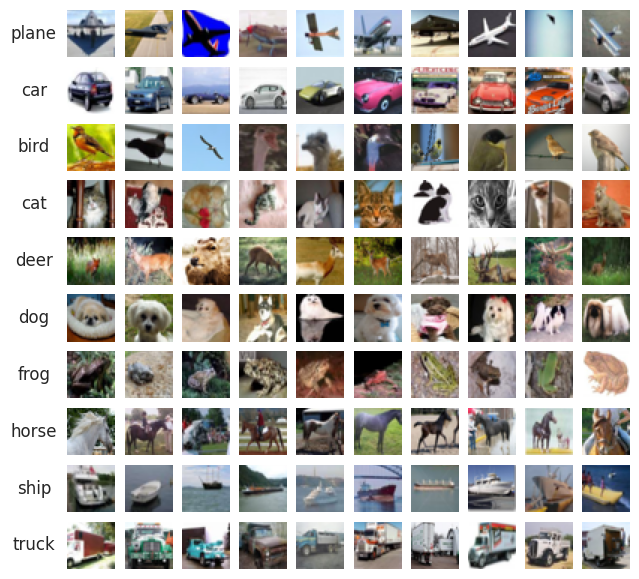

In [ ]:
def collate(batch):
    images, labels = zip(*batch)
    images = [np.array(img) for img in images]
    images = np.array(images)
    labels = torch.tensor(labels)
    return torch.tensor(images).permute(0, 3, 1, 2), labels

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, collate_fn=collate)

def imshow(img):
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

dataiter = iter(trainloader)
images, labels = next(dataiter)

class_images = {class_label: [] for class_label in range(10)}
for img, label in zip(images, labels):
    if len(class_images[label.item()]) < 10:
        class_images[label.item()].append(img.numpy())

plt.figure(figsize=(8,8))
sns.set_style('white')

for class_idx, class_label in enumerate(classes):
    plt.subplot(11, 11, class_idx * 11 + 1)
    plt.text(0.5, 0.5, class_label, ha='center', va='center', fontsize=12)
    plt.axis('off')

for class_idx, (class_label, img_list) in enumerate(class_images.items()):
    for img_num, img in enumerate(img_list):
        plt.subplot(11, 11, class_idx * 11 + img_num + 2)
        imshow(img)
plt.show()

In [ ]:
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.RandomErasing(p=0.1)
])

In [ ]:
train_dset = datasets.CIFAR10(root=args.DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=args.DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


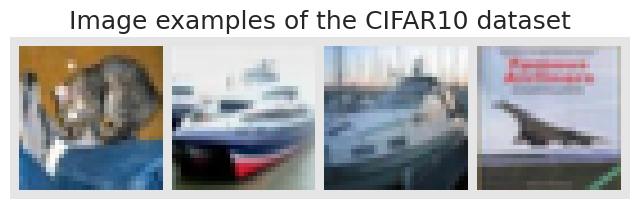

In [ ]:
NUM_IMAGES = 4
CIFAR_images = torch.stack([test_dset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0).numpy()

sns.set(style="whitegrid", context="talk", palette="rainbow")

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Args:
        x: Tensor representing the image of shape [B, C, H, W]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

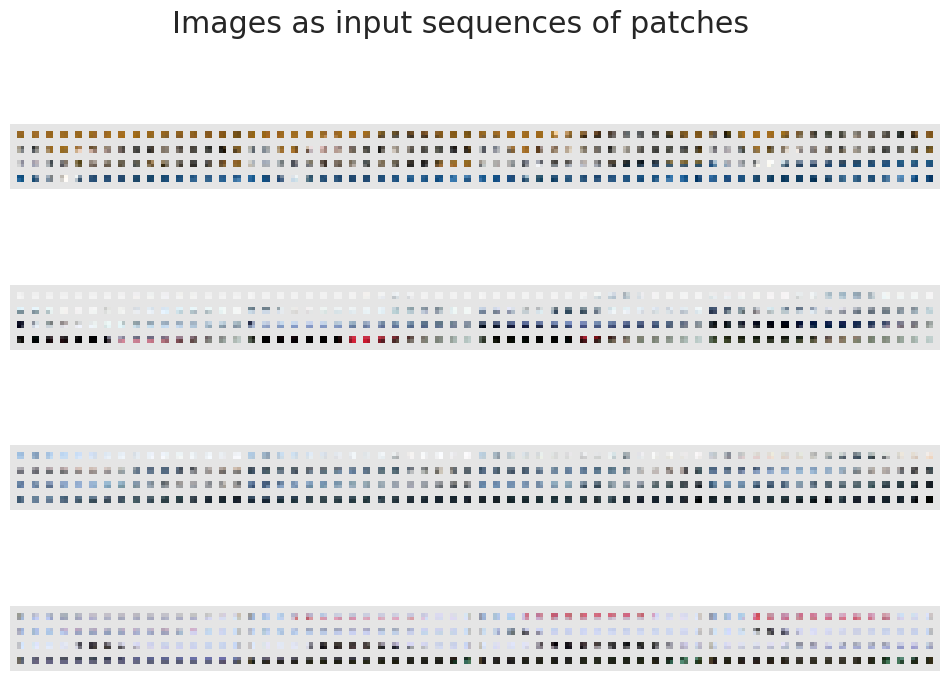

In [ ]:
img_patches = img_to_patch(CIFAR_images, patch_size=2, flatten_channels=False)

sns.set(style="whitegrid", context="talk", palette="rainbow")

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(12, 8))
fig.suptitle("Images as input sequences of patches")

for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0).numpy()

    ax[i].imshow(img_grid)
    ax[i].axis("off")

plt.show()
plt.close()

Image size: 32 X 32
Patch size: 2 X 2
Patches per image: 256
Elements per patch: 2


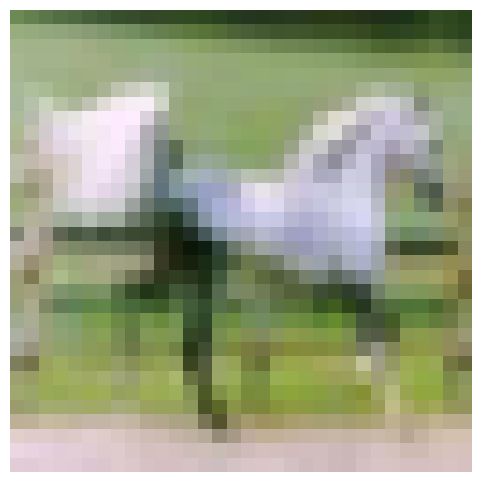

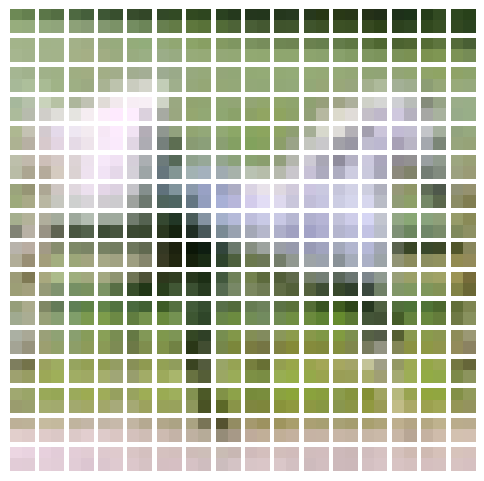

In [ ]:
class Patches(nn.Module):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        batch_size, channels, height, width = images.size()
        patches = images.unfold(1, 3, 3).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, -1, 3, self.patch_size, self.patch_size)
        return patches

dataiter = iter(trainloader)
images, labels = next(dataiter)
image = images[0]

class Config:
    image_size = 32
    patch_size = 2

plt.figure(figsize=(6, 6))
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis("off")

resized_image = torch.nn.functional.interpolate(image.unsqueeze(0), size=(Config.image_size, Config.image_size), mode='nearest')
patches = Patches(Config.patch_size)(resized_image)
print(f"Image size: {Config.image_size} X {Config.image_size}")
print(f"Patch size: {Config.patch_size} X {Config.patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patch.permute(1, 2, 0).numpy()
    plt.imshow(patch_img)
    plt.axis("off")

plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=args.BATCH_SIZE, shuffle=True,
                                           num_workers=args.NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=args.BATCH_SIZE, shuffle=False,
                                          num_workers=args.NUM_WORKERS, pin_memory=True)

## Model

In [ ]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return x + self.gamma * self.residual(x)


class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

In [ ]:
class SelfAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, head_channels, shape):
        super().__init__()
        self.heads = out_channels // head_channels
        self.head_channels = head_channels
        self.scale = head_channels**-0.5

        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)

        height, width = shape
        self.pos_enc = nn.Parameter(torch.Tensor(self.heads, (2 * height - 1) * (2 * width - 1)))
        self.register_buffer("relative_indices", self.get_indices(height, width))

    def forward(self, x):
        b, _, h, w = x.shape

        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)

        att = keys.transpose(-2, -1) @ queries

        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.pos_enc.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))

        att = att * self.scale + rel_pos_enc
        att = F.softmax(att, dim=-2)

        out = values @ att
        out = out.view(b, -1, h, w)
        out = self.unifyheads(out)
        return out

    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)

        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()

        return indices

In [ ]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1)
        )

In [ ]:
class TransformerBlock(nn.Sequential):
    def __init__(self, channels, head_channels, shape, p_drop=0.):
        super().__init__(
            Residual(
                LayerNormChannels(channels),
                SelfAttention2d(channels, channels, head_channels, shape),
                nn.Dropout(p_drop)
            ),
            Residual(
                LayerNormChannels(channels),
                FeedForward(channels, channels),
                nn.Dropout(p_drop)
            )
        )

In [ ]:
class TransformerStack(nn.Sequential):
    def __init__(self, num_blocks, channels, head_channels, shape, p_drop=0.):
        layers = [TransformerBlock(channels, head_channels, shape, p_drop) for _ in range(num_blocks)]
        super().__init__(*layers)

In [ ]:
class ToPatches(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, hidden_channels=32):
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, channels, patch_size, stride=patch_size)
        )

In [ ]:
class AddPositionEmbedding(nn.Module):
    def __init__(self, channels, shape):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.Tensor(channels, *shape))

    def forward(self, x):
        return x + self.pos_embedding

In [ ]:
class ToEmbedding(nn.Sequential):
    def __init__(self, in_channels, channels, patch_size, shape, p_drop=0.):
        super().__init__(
            ToPatches(in_channels, channels, patch_size),
            AddPositionEmbedding(channels, shape),
            nn.Dropout(p_drop)
        )

In [ ]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(in_channels),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [ ]:
class ViT(nn.Sequential):
    """
    Vision Transformer model using CutMix.

    Args:
        classes (int): Number of output classes.
        image_size (int): The size of the input images (assumed to be square).
        channels (int): The number of channels in the input images.
        head_channels (int): The number of channels in the transformer heads.
        num_blocks (int): The number of transformer blocks.
        patch_size (int): The size of the patches to divide the images into.
        in_channels (int, optional): The number of input channels. Default is 3 (RGB).
        emb_p_drop (float, optional): Dropout probability for the embedding layer. Default is 0.
        trans_p_drop (float, optional): Dropout probability for the transformer layer. Default is 0.
        head_p_drop (float, optional): Dropout probability for the head layer. Default is 0.

    Attributes:
        parameters_decay (set): Set of parameters that will have weight decay applied during optimization.
        parameters_no_decay (set): Set of parameters that will not have weight decay applied during optimization.
    """

    def __init__(self, classes, image_size, channels, head_channels, num_blocks, patch_size,
                 in_channels=3, emb_p_drop=0., trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_size
        shape = (reduced_size, reduced_size)
        super().__init__(
            ToEmbedding(in_channels, channels, patch_size, shape, emb_p_drop),
            TransformerStack(num_blocks, channels, head_channels, shape, trans_p_drop),
            Head(channels, classes, head_p_drop)
        )
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, AddPositionEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
            elif isinstance(m, SelfAttention2d):
                nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        parameters_decay = set()
        parameters_no_decay = set()
        modules_weight_decay = (nn.Linear, nn.Conv2d)
        modules_no_weight_decay = (nn.LayerNorm,)

        for m_name, m in self.named_modules():
            for param_name, param in m.named_parameters():
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name

                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name)
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, AddPositionEmbedding) and param_name.endswith("pos_embedding"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                    parameters_no_decay.add(full_param_name)
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name)

        assert len(parameters_decay & parameters_no_decay) == 0
        assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

        return parameters_decay, parameters_no_decay

### Flops

In [ ]:
import warnings
warnings.filterwarnings("ignore")

if __name__ == "__main__":
    model = ViT(args.NUM_CLASSES, args.IMAGE_SIZE, channels=args.CHANNELS, head_channels=args.HEAD_CHANNELS, num_blocks=args.NUM_BLOCKS, patch_size=args.PATCH_SIZE,
               emb_p_drop=args.EMB_P_DROP, trans_p_drop=args.TRANS_P_DROP, head_p_drop=args.HEAD_P_DROP).to(DEVICE)
    model.eval()
    inputs = torch.randn(1, 3, 32, 32).to(DEVICE)
    model(inputs)

    from fvcore.nn import FlopCountAnalysis, ActivationCountAnalysis, flop_count_table

    flops = FlopCountAnalysis(model, inputs)
    param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    acts = ActivationCountAnalysis(model, inputs)

    print(f"total flops : {flops.total()}")
    print(f"total activations: {acts.total()}")
    print(f"number of parameter: {param}")

    print(flop_count_table(flops, max_depth=1))

total flops : 1893960192


total activations: 9535498
number of parameter: 6482138
| module   | #parameters or shape   | #flops   |
|:---------|:-----------------------|:---------|
| model    | 6.482M                 | 1.894G   |
|  0       |  99.456K               |  9.273M  |
|  1       |  6.38M                 |  1.884G  |
|  2       |  3.082K                |  0.396M  |


In [ ]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,482,138


### Cutmix

In [ ]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [ ]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()

    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)

        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)

        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]

        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y

    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)

        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))

    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

### Optimizer

In [ ]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = model.separate_parameters()

    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Cosine Annealing LR Schedule

In [ ]:
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
loss = nn.CrossEntropyLoss(label_smoothing=args.LABEL_SMOOTHING)
cutmix = CutMix(loss, α=0.5)

optimizer = get_optimizer(model, learning_rate=args.LEARNING_RATE, weight_decay=args.WEIGHT_DECAY)
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)

lr_scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=50, cycle_mult=args.CYCLE_MULT, max_lr=args.LEARNING_RATE,
                                             min_lr=args.MIN_LR, warmup_steps=args.WARM_UP, gamma=args.GAMMA)

ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

history = defaultdict(list)

In [ ]:
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 1e-05
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 1e-05
    maximize: False
    weight_decay: 0.0
)


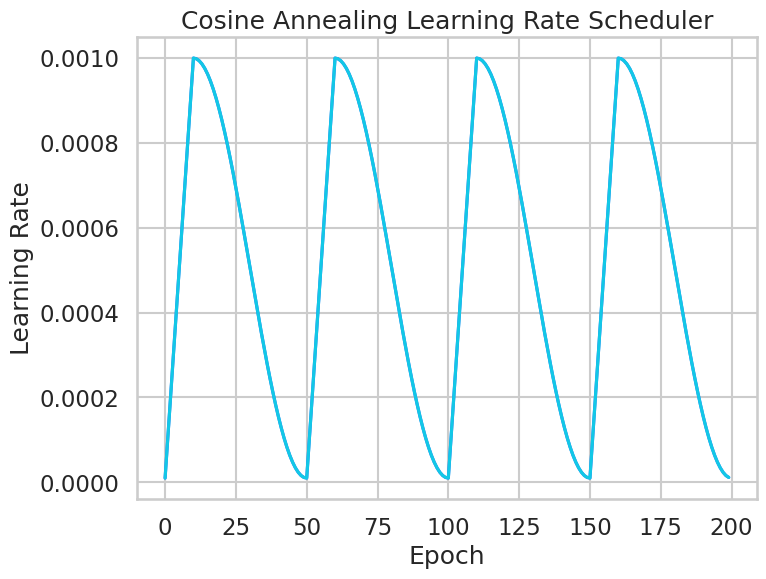

In [ ]:
lrs = []
for epoch in range(200):
    lr_scheduler.step(epoch)
    lrs.append(lr_scheduler.get_lr())

plt.figure(figsize=(8,6))
plt.plot(lrs)
plt.title('Cosine Annealing Learning Rate Scheduler')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

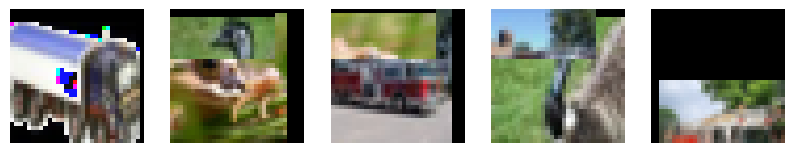

In [ ]:
def plot_cutmix_images(model, data_loader, device):

    images, labels = next(iter(data_loader))
    mixed_images, _ = model.prepare_batch((images, labels), device=DEVICE, non_blocking=True)
    np_images = mixed_images.cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, ax in enumerate(axes):
        # Transpose the image from (C, H, W) to (H, W, C) and normalize
        img = np.transpose(np_images[i], (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img)
        ax.axis('off')
    plt.show()

cutmix_model = CutMix(loss = loss, α = args.ALPHA)
cifar10_loader = torch.utils.data.DataLoader(train_dset, batch_size=5, shuffle=True,
                                           num_workers=args.NUM_WORKERS, pin_memory=True)

plot_cutmix_images(cutmix_model, cifar10_loader, device=DEVICE)

### Training

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    current_lr = lr_scheduler.get_lr()
    print(f"Learning rate updated to: {current_lr}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)

    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)

    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [ ]:
import time

start_time = time.time()

trainer.run(train_loader, max_epochs=args.EPOCHS)

end_time = time.time()

training_time = end_time - start_time

print(f"Training time: {training_time} seconds")

Learning rate updated to: [1e-05, 1e-05]
1/200 - train: loss 2.368; val: loss 2.281 accuracy 0.156
Learning rate updated to: [0.00010899999999999999, 0.00010899999999999999]
2/200 - train: loss 2.315; val: loss 2.223 accuracy 0.191
Learning rate updated to: [0.000208, 0.000208]
3/200 - train: loss 2.198; val: loss 1.982 accuracy 0.289
Learning rate updated to: [0.00030700000000000004, 0.00030700000000000004]
4/200 - train: loss 2.088; val: loss 1.669 accuracy 0.473
Learning rate updated to: [0.000406, 0.000406]
5/200 - train: loss 2.031; val: loss 1.567 accuracy 0.548
Learning rate updated to: [0.000505, 0.000505]
6/200 - train: loss 1.981; val: loss 1.503 accuracy 0.552
Learning rate updated to: [0.000604, 0.000604]
7/200 - train: loss 1.953; val: loss 1.417 accuracy 0.592
Learning rate updated to: [0.0007030000000000001, 0.0007030000000000001]
8/200 - train: loss 1.922; val: loss 1.349 accuracy 0.623
Learning rate updated to: [0.000802, 0.000802]
9/200 - train: loss 1.940; val: loss 

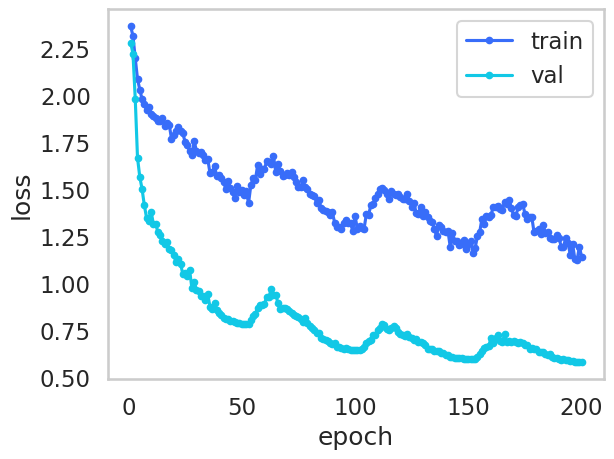

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.grid()
plt.show()

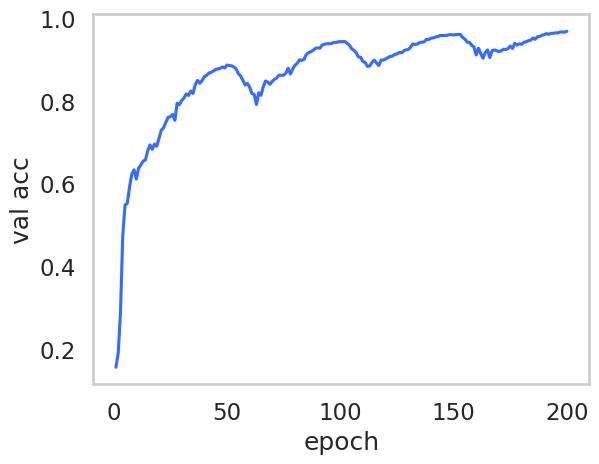

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
ax.grid()
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()